<img src='http://imgur.com/1ZcRyrc.png' style='float: left; margin: 20px; height: 55px'>


# DSI-SG-42 Capstone Project:
### Silent Echoes: From Hand Waves to Written Phrases

MediaPipe provides pre-trained machine learning models for various landmark detection tasks. The available models are optimized for real-time performance and can process video streams easily, making it a suitable tool for action/gesture recognition. 

## MediaPipe Face Landmarker: Analyze Facial Movement in Videos

The model detects 468 crucial points on the face providing a comprehensive representation of how the face would look like like a mask. 

Facial outline:
- Forhead contour
- Eyebrows
- Bridge of the nose
- Tip and base of the nose
- Chin contour
- Jawline

Eyes:
- Inner and outer corners
- Upper and lower eyelids

Mouth:
- Corners of the mouth
- Upper and lower lips


These landmarks provide information whether if the person is smiling or frowning with the changes in the extensive landmark values.

![Face Landmarks](../images/face_landmark.png)

## MediaPipe Pose Landmarker: Analyze Body Movement in Videos

This tool lets you extract key body points (landmarks) from video footage. You can then analyze a person's posture and movement in real-time.

What it Detects:

- Full Body: Tracks skeletal movement, like shoulders, hips, knees, and elbows.
- Face: Detects key facial points for expression analysis (eyes, eyebrows, nose, lips).
- Hands: Identifies fingertips (thumb, index, pinky) and wrist for gesture recognition.
- Feet: Tracks ankle, heel, and toes for footwork analysis.


<div style='display: flex;'>
    <img src='../images/pose_landmarks_index.png' alt='Pose Landmark' style='width: 50%; height: auto;'>
    <img src='../images/pose_landmarks_legend.jpg' alt='Pose Landmark Legend' style='width: 30%; height: auto;'>
</div>

#### MediaPipe Hands Landmarker: Analyze Hand Movements in Videos

Focus on Your Hand landmarks:

- Precise Tracking: It accurately tracks 21 keypoints on each hand, including fingertips (thumb, index, pinky, etc.), palm center, and wrist.
- Real-Time Performance: Optimized for efficient processing, enabling smooth hand tracking in various applications.
- Handedness Detection: Identifies the left or right hand, making it suitable for analyzing gestures involving both hands.
    


<img src='../images/hand-landmarks.png' width=50% height=50%>

Explanations for each sign word:

- **Please**: In ASL, `'please'` is often expressed by placing the palm facing down, and moving it in a circular motion over your chest in a clockwise direction. This sign is often accompanied by a pleading facial expression to convey politeness and sincerity.


- **Sorry**: The sign for `'sorry'` in ASL involves placing one hand over your heart, fingers together and pointing downward, and making a small circular motion. This sign is typically accompanied by a remorseful facial expression to convey genuine regret or apology.


- **Hello**: To say `'hello'` in ASL, you can use a simple wave gesture. Extend your dominant hand with fingers spread apart and move it slightly side to side in front of your body. You can also combine this with a friendly facial expression to greet someone warmly.

# 3. Exploratory Data Analysis

In [1]:
# import libraries
import os
import csv
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mediapipe as mp
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# set plot theme
plt.style.use('ggplot')

# set display settings
%matplotlib inline
pd.set_option('display.width', 100000)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

In [2]:
# recalling the action words
first_three = ['please', 'sorry', 'hello']

#### Total Videos Available from the datasets


In [3]:
# the total number of raw videos available from the downloads
please_vid_path = os.listdir('../videos/train_data/please') # 'please'
sorry_vid_path = os.listdir('../videos/train_data/sorry') # 'sorry'
hello_vid_path = os.listdir('../videos/train_data/hello') # 'thank you'

print(f'''
Total downloaded videos for the following signed words:
    please: {len(please_vid_path)}
    sorry: {len(sorry_vid_path)}
    hello: {len(hello_vid_path)}
''')


Total downloaded videos for the following signed words:
    please: 20
    sorry: 11
    hello: 16



#### Total Available Videos After Cropping

In [4]:
# total number of cropped videos after processing
please_vid_cropped_path = os.listdir('../videos/train_data/please/cropped_videos') # 'please'
sorry_vid_cropped_path = os.listdir('../videos/train_data/sorry/cropped_videos') # 'sorry'
hello_vid_cropped_path = os.listdir('../videos/train_data/hello/cropped_videos') # 'thank you'

print(f'''
Total downloaded videos for the following signed words:
    please: {len(please_vid_cropped_path)}
    sorry: {len(sorry_vid_cropped_path)}
    hello: {len(hello_vid_cropped_path)}
''')


Total downloaded videos for the following signed words:
    please: 29
    sorry: 18
    hello: 17



There is an increase in the number of videos as the videos have repeated action of the same word which is cropped to produce additional videos

In [5]:
increase_please = len(please_vid_cropped_path) - len(please_vid_path)
increase_sorry = len(sorry_vid_cropped_path) - len(sorry_vid_path)
increase_hello = len(hello_vid_cropped_path) - len(hello_vid_path)

print(f'''

After cropping we have additional samples from the following action classes:
    please: {increase_please}
    sorry: {increase_sorry}
    hello: {increase_hello}

''')



After cropping we have additional samples from the following action classes:
    please: 9
    sorry: 7
    hello: 1




In [6]:
# percentage of videos in each class

total_videos = len(please_vid_cropped_path) + len(sorry_vid_cropped_path) + len(hello_vid_cropped_path)

num_classes = len(first_three)

prop_please = len(please_vid_cropped_path) / total_videos

prop_sorry = len(sorry_vid_cropped_path) / total_videos

prop_hello = len(hello_vid_cropped_path) / total_videos


print(f'''
The proportion of videos of each of the action classes in the {num_classes} classes in the train dataset:
please: {prop_please:.2%}
sorry: {prop_sorry:.2%}
hello: {prop_hello:.2%}

''')


The proportion of videos of each of the action classes in the 3 classes in the train dataset:
please: 45.31%
sorry: 28.12%
hello: 26.56%




There are class imbalances between the 3 action classes with 44.12% of videos belonging to action class *please*. 
The action class of *sorry* and *hello* are closely similar in proportion at 28 and 26%. However, we will have to address this during the modeling phase.

## 3.2 Visual inspection of videos

In [7]:
### Define functions for video 

# Assign and initiate MediaPipe tools

mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utililties

# to perform pose estimation
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Color conversion BGR 2 RGB
    image.flags.writeable = False # Image is no longer writeable
    results = model.process(image) # make predictions
    image.flags.writeable = True # Image is now writeable
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # Color conversion RGB 2 BGR
    return image, results


# visualize the drawing of landmarks and connections on the body
def draw_landmarks(image, results):
            
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                            mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                            mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                            ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                            mp_drawing.DrawingSpec(color=(255,0,0), thickness=2, circle_radius=4), 
                            mp_drawing.DrawingSpec(color=(0,255,255), thickness=2, circle_radius=2)
                            ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                            mp_drawing.DrawingSpec(color=(0,255,0), thickness=2, circle_radius=4), 
                            mp_drawing.DrawingSpec(color=(255,255,0), thickness=2, circle_radius=2)
                            )    
    

In [8]:
# extracting keypoints if none detected fill rows with zeroes
def extract_keypoints(results, which_hand):
    
    if which_hand == 'left':
        keypoints = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    elif which_hand == 'right':
        keypoints = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3) 

    return keypoints

## 3.3 Inspect Frames with Landmarks

In [9]:
# define a function to show still images from a start to an end frame number
def sample_and_plot_frames(video_path, start_frame=15, end_frame=25):
    cap = cv2.VideoCapture(video_path) # create video capture object
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) # obtain total number of frames in the video
    
    # Determine which frames to capture
    num_frames = end_frame - start_frame + 1
    frame_indices = np.linspace(start_frame, end_frame, num_frames, dtype=int)
    
    # initialize MediaPipe Holistic Model
    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        frames_processed = 0 
        sampled_frames = []
        frame_id = 0
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            # perform detection using MediaPipe
            image, results = mediapipe_detection(frame, holistic)
            # Draw landmarks on the frame
            draw_landmarks(image, results)
            
            if frame_id in frame_indices:
                # Convert frame from BGR to RGB
                frame_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Use the modified image with landmarks
                sampled_frames.append(frame_rgb)
            frame_id += 1

        cap.release()
        
        # Plotting the frames
        num_rows = int(np.ceil(num_frames / 10))  # Determine number of rows needed
        plt.figure(figsize=(20, 2 * num_rows))
        for i, frame in enumerate(sampled_frames):
            plt.subplot(num_rows, 10, i + 1)
            plt.imshow(frame)
            plt.axis('off')  # Turn off axis labels
        plt.tight_layout()
        plt.show()


###  3.3.1 'Please' Sign Action

We want to visually see variable each of the signer execute the action word.

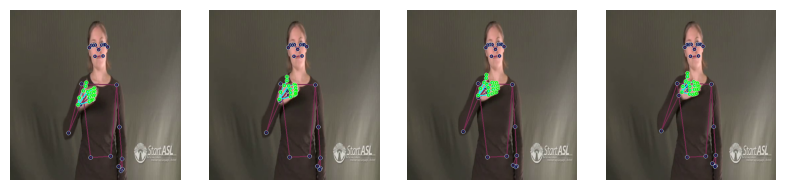

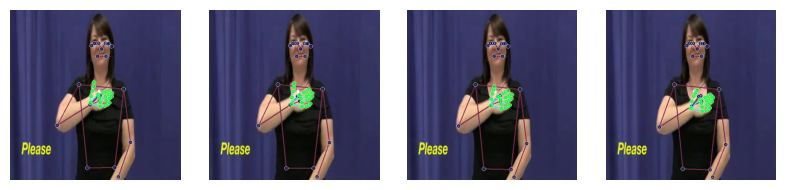

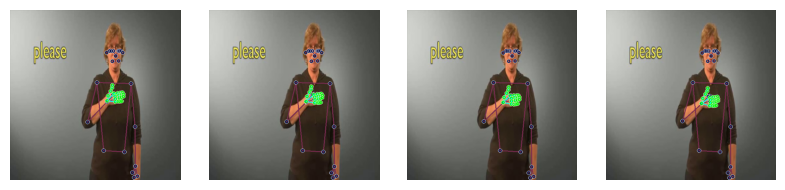

In [10]:
# plot 4 frames from the first 3 videos of the folder

# Original video clips
VIDEO_DIRECTORY = '../videos/train_data/output/please/'

max_video = 3
count = 0
for vid in os.listdir(VIDEO_DIRECTORY):
    video_path = os.path.join(VIDEO_DIRECTORY, vid)
    #print(video_path)

    sample_and_plot_frames(video_path, 17,20)
    count +=1

    # break loop
    if count == max_video:
        break

We can see that the all 3 signers sign somewhat differently. The first signer signs closer to the throat with her fingers close together with her thumb point directly upwards. While the second signer signs slightly lower with the fingers slightly spread out and flat on the chest. The third signer signs in the middle of her chest lower than the first two signers. 

### 3.3.1.1 'Please' Original and Augmented Video Clips

We are now able to plot the images that have been augmented. The first image will be the original clip.

In [15]:
# the number videos in the folder
VIDEOS_PER_SET = len(please_vid_cropped_path)

print(f'The total number of original videos: {VIDEOS_PER_SET}')

The total number of original videos: 29


Please 


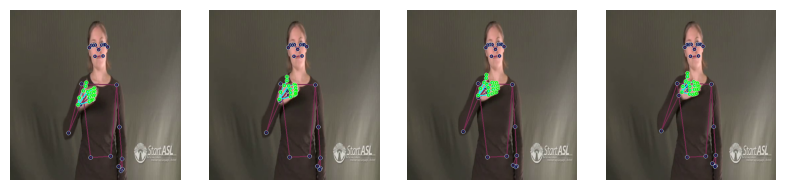

Please Darkened 


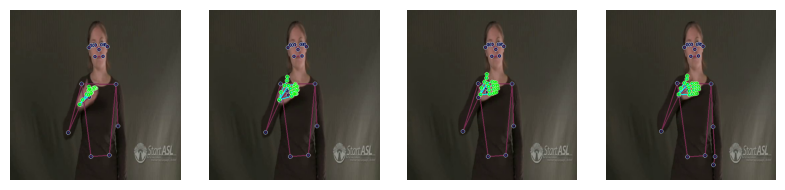

Please Decrease Contrast 


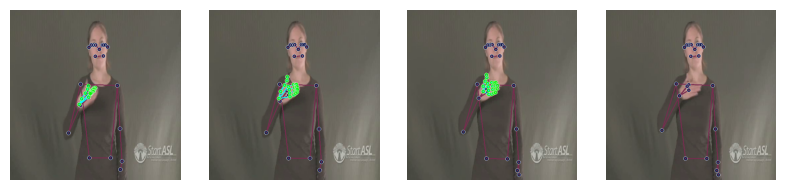

Please Flipped 


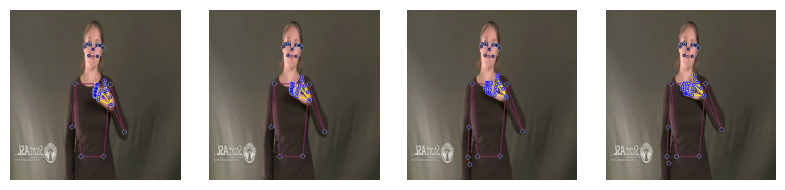

Please Gblur 


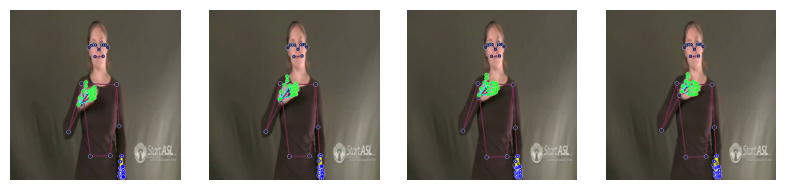

Please Increase Contrast 


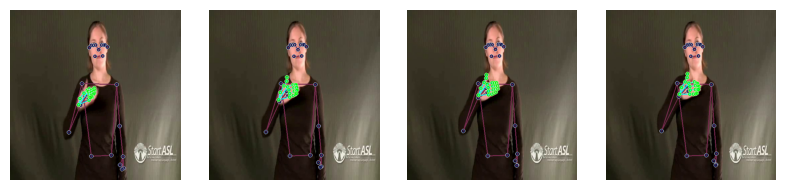

Please Shear Negative 


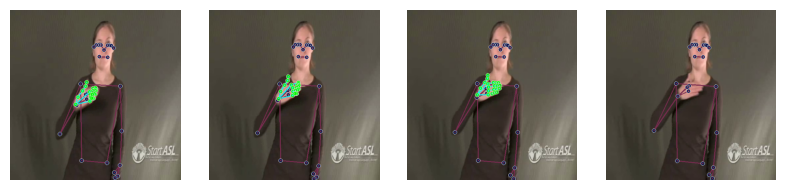

Please Shear Positive 


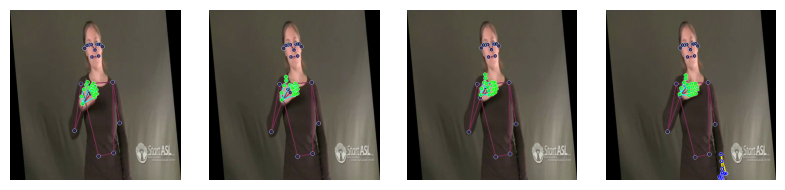

In [16]:
# video directory of the action 'please'
VIDEO_DIRECTORY = '../videos/train_data/output/please/'

# Initialize counter
counter = 0

# Iterate through files in the directory
for filename in os.listdir(VIDEO_DIRECTORY):
    # Check if the file is a video file
    if filename.endswith('.mp4'):
        # Increment the counter
        counter += 1
        
        # Check if the counter is a multiple of the number of videos per set so we plot the same signer
        if counter % VIDEOS_PER_SET == 1:
            # Construct the full path to the video file
            video_path = os.path.join(VIDEO_DIRECTORY, filename)

            # Construct the full path to the video file
            video_path = os.path.join(VIDEO_DIRECTORY, filename)
            file_name = filename.replace('1.mp4', '').split('_')
            file_name = (' ').join(file_name).title()
            print(file_name)
            
            # Call the function to sample and plot frames for this video file
            sample_and_plot_frames(video_path, 17 ,20)


Through different augmentations, we can generate more samples by changing the conditions of the video. MediaPipe is able to capture the wrist movement of most of the frames. 

## 3.3.2 'Sorry' Sign Action

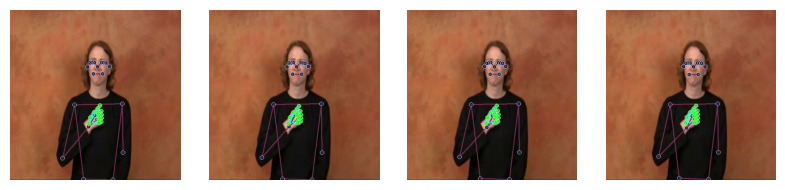

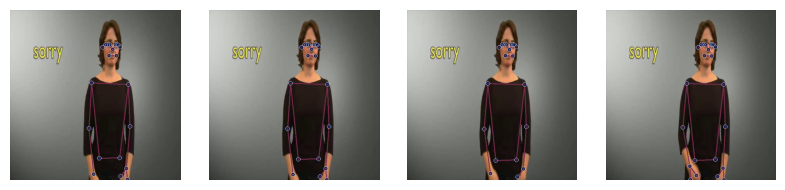

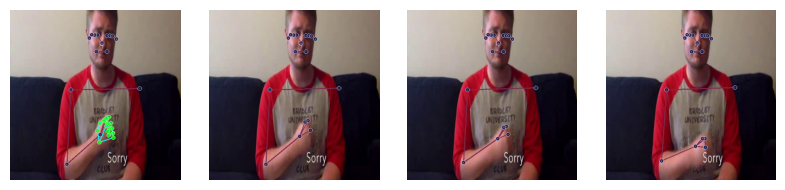

In [17]:
# plot 4 frames from the first 3 videos of the folder

# Original video clips
VIDEO_DIRECTORY = '../videos/train_data/output/sorry/'

max_video = 3
count = 0
for vid in os.listdir(VIDEO_DIRECTORY):
    video_path = os.path.join(VIDEO_DIRECTORY, vid)
    #print(video_path)

    sample_and_plot_frames(video_path, 17,20)
    count +=1

    if count == max_video:
        break

Among the 3 video of diferent signers, the first set of images capture how the person signs the word `sorry`. The signer's closes her palm into a fist with the thumb placed above and rubs her chest in a circular motion. The position is closer to the centre and consistent. 

The second set of images does not show the the action of the sign.

The last set of images shows a variation in signing where the fist is placed lower on the chest with the fist angled slightly outwards. In this set of images MediaPipe is having difficulties capturing the fingers as it is not shown on the frame.

### 3.3.2.1 Original and Augmented Video Clips

We are now able to plot the images that have been augmented. The first image will be the original clip.

Sorry 


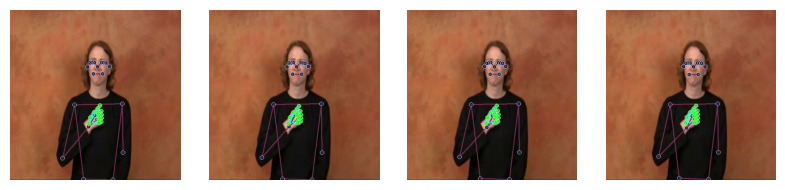

Sorry Darkened 


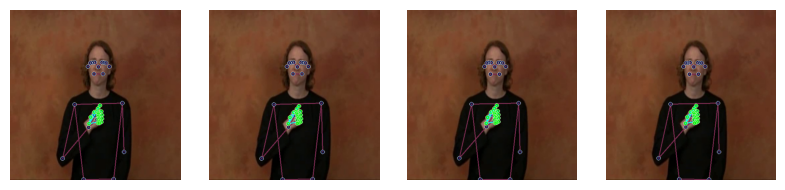

Sorry Decrease Contrast 


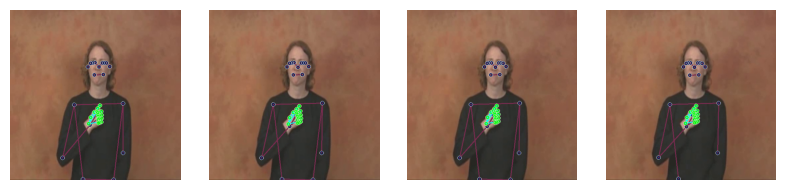

Sorry Flipped 


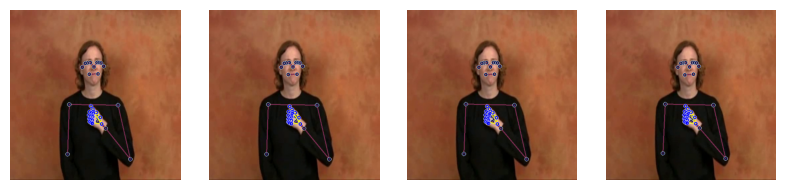

Sorry Gblur 


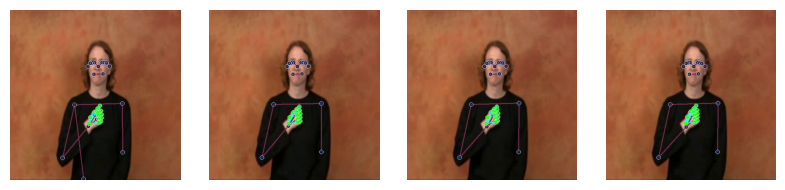

Sorry Increase Contrast 


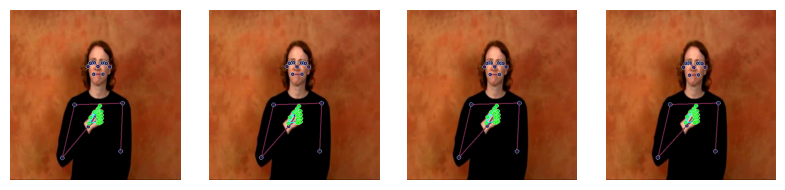

Sorry Shear Negative 


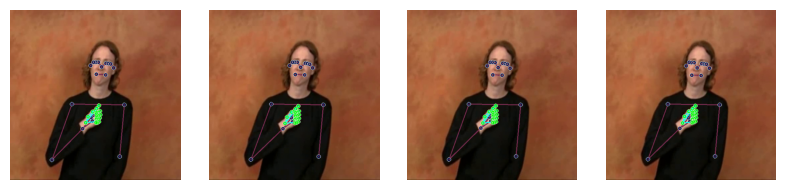

Sorry Shear Positive 


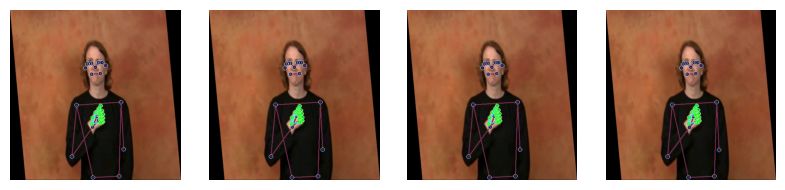

In [18]:
# video directory of the action 'sorry'
VIDEO_DIRECTORY = '../videos/train_data/output/sorry/'

# the number videos in the folder
VIDEOS_PER_SET = len(sorry_vid_cropped_path)

# Initialize counter
counter = 0

# Iterate through files in the directory
for filename in os.listdir(VIDEO_DIRECTORY):
    # Check if the file is a video file
    if filename.endswith('.mp4'):
        # Increment the counter
        counter += 1
        
        # Check if the counter is a multiple of 17
        if counter % VIDEOS_PER_SET == 1:
            # Construct the full path to the video file
            video_path = os.path.join(VIDEO_DIRECTORY, filename)
            file_name = filename.replace('1.mp4', '').split('_')
            file_name = (' ').join(file_name).title()
            print(file_name)
            
            # Call the function to sample and plot frames for this video file
            sample_and_plot_frames(video_path, 17 ,20)


Similar to the `please` action, MediaPipe is able to capture the wrist movement and landmarks from this particular signer and augmentations.

### 3.3.3 'Hello' Sign Action

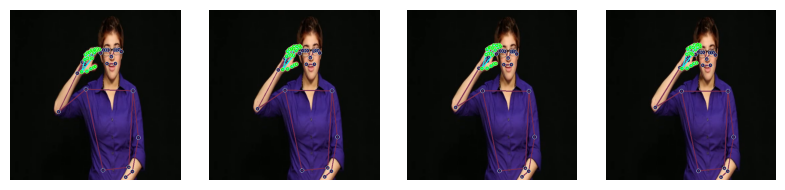

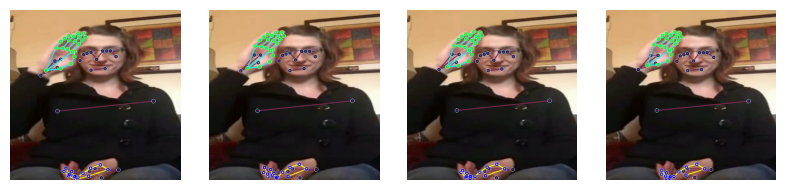

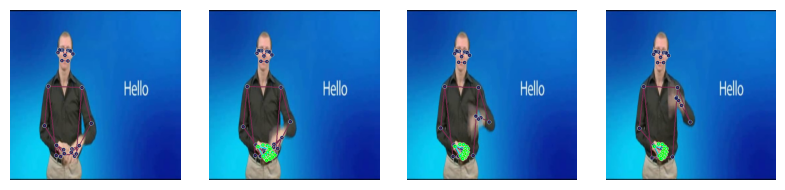

In [19]:
# plot 4 frames from the first 3 videos of the folder

# Original video clips
VIDEO_DIRECTORY = '../videos/train_data/output/hello/'

max_video = 3
count = 0
for vid in os.listdir(VIDEO_DIRECTORY):
    video_path = os.path.join(VIDEO_DIRECTORY, vid)
    #print(video_path)

    sample_and_plot_frames(video_path, 17,20)
    count +=1

    if count == max_video:
        break

The action for `hello` is very similar to a salute where the palm is open and fingers are generally closed together. The palm is then placed on the forehead as a start which will be thrust upwards mid-phase. 

In the first set of images, we see a variation that the signer bends her fingers and place it on her eyebrows.

In the second set of images, the signer places her index finger on her forhead with the insides of her palm facing outwards.

In the last set of images, we can see that the signer is about to place his left hand on his forehead. Due to the signer's speed of movement, MediaPipe is unable to capture the landmarks on his hands

####  3.3.3.1 Original and Augmented Video Clips

Hello 


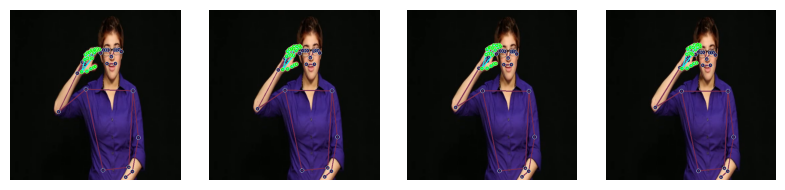

Hello Darkened 


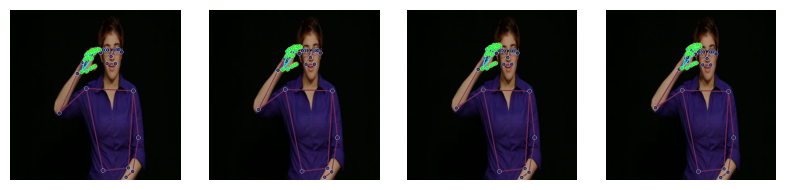

Hello Decrease Contrast 


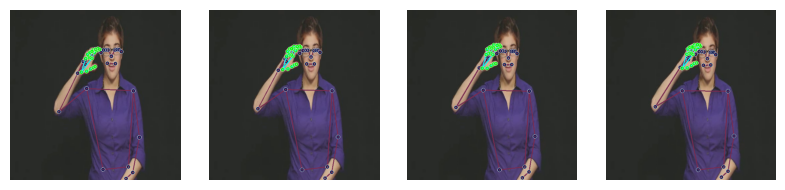

Hello Flipped 


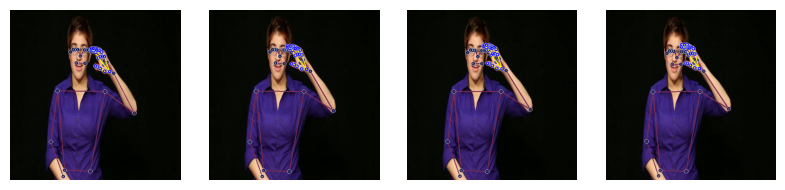

Hello Gblur 


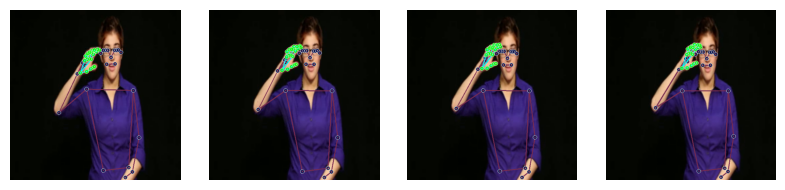

Hello Increase Contrast 


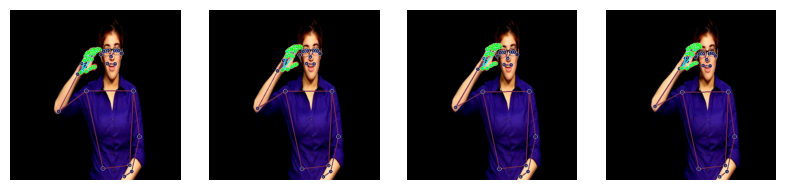

Hello Shear Negative 


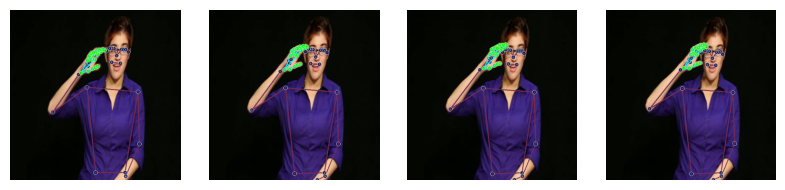

Hello Shear Positive 


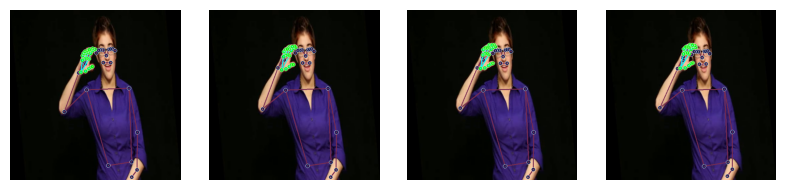

In [20]:
# video directory of the action 'sorry'
VIDEO_DIRECTORY = '../videos/train_data/output/hello/'

# the number videos in the folder
VIDEOS_PER_SET = len(hello_vid_cropped_path)

# Initialize counter
counter = 0

# Iterate through files in the directory
for filename in os.listdir(VIDEO_DIRECTORY):
    # Check if the file is a video file
    if filename.endswith('.mp4'):
        # Increment the counter
        counter += 1
        
        # Check if the counter is a multiple of 17
        if counter % VIDEOS_PER_SET == 1:
            # Construct the full path to the video file
            video_path = os.path.join(VIDEO_DIRECTORY, filename)

            # Construct the full path to the video file
            video_path = os.path.join(VIDEO_DIRECTORY, filename)
            file_name = filename.replace('1.mp4', '').split('_')
            file_name = (' ').join(file_name).title()
            print(file_name)

            
            
            # Call the function to sample and plot frames for this video file
            sample_and_plot_frames(video_path, 17 ,20)


Similar to the past 2 signs, MediaPipe is able to capture the wrist movement and landmarks from this particular signer and augmentations.

## 3.4 Analysis of Hand Movement With Landmark Values

In MediaPipe's library, each landmark denotes a position of the body. According to the documentation from [MediaPipe](https://developers.google.com/mediapipe/solutions/vision/hand_landmarker), each designated notation is assigned to the parts of the hand which we can form a dictionary. This would allow the dataframe to be more descriptive. 

The expansion of the acronym is as follows:
 - Thumb landmarks
    - `thumb_cmc`: Carpometacarpal joint - The point where the thumb connects to the palm
    - `thumb_mcp`: Metacarpophalangeal joint - The knuckle joint at the base of the thumb
    - `thumb_ip`: Interphalangeal joint - The middle joint of the thumb (if present)
    - `thumb_tip`: The tip of the thumb.
 - Finger landmarks
    - `mcp`: Metacarpophalangeal joint - The knuckle joint at the base of the finger
    - `pip`: Proximal Interphalangeal - The middle joint of the finger
    - `dip`: Distal Interphalangeal joint - The outermost joint of the finger (optional for some fingers)
    - `tip`: Tip - The tip of the finger.

In [21]:
# Dictionary of hand landmarks
palm_landmarks = {
    0: 'wrist',
    1: 'thumb_cmc',
    2: 'thumb_mcp',
    3: 'thumb_ip',
    4: 'thumb_tip',
    5: 'index_finger_mcp',
    6: 'index_finger_pip',
    7: 'index_finger_dip',
    8: 'index_finger_tip',
    9: 'middle_finger_mcp',
    10: 'middle_finger_pip',
    11: 'middle_finger_dip',
    12: 'middle_finger_tip',
    13: 'ring_finger_mcp',
    14: 'ring_finger_pip',
    15: 'ring_finger_dip',
    16: 'ring_finger_tip',
    17: 'pinky_mcp',
    18: 'pinky_pip',
    19: 'pinky_dip',
    20: 'pinky_tip'
}


In [22]:
# Ensure the data directory exists
data_directory = '../data'
os.makedirs(data_directory, exist_ok=True)

# Process each action
for action in first_three:
    headers = ['action', 'frame'] + [f'{palm_landmarks[i].upper()}_{dim}' for i in range(21) for dim in ['x', 'y', 'z']]
    
    # Files for left and right hand landmarks
    left_file = os.path.join(data_directory, f'{action}_left_hand_landmarks.csv')
    right_file = os.path.join(data_directory, f'{action}_right_hand_landmarks.csv')

    # Write headers for both files
    with open(left_file, 'w', newline='') as file_left, open(right_file, 'w', newline='') as file_right:
        writer_left = csv.writer(file_left)
        writer_right = csv.writer(file_right)
        writer_left.writerow(headers)
        writer_right.writerow(headers)

    # List of videos directory
    LIST_OF_VID = os.path.join('../videos/train_data/output/', action)
    for vid in os.listdir(LIST_OF_VID):
        video_path = os.path.join(LIST_OF_VID, vid)
        cap = cv2.VideoCapture(video_path)

        # Append mode for CSV files
        with open(left_file, 'a', newline='') as file_left, open(right_file, 'a', newline='') as file_right:
            writer_left = csv.writer(file_left)
            writer_right = csv.writer(file_right)

            # Setup MediaPipe model
            with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
                frame_count = 0
                while cap.isOpened():
                    ret, frame = cap.read()
                    if not ret:
                        break

                    # Make detections
                    image, results = mediapipe_detection(frame, holistic)

                    # Draw landmarks
                    draw_landmarks(image, results)

                    # Extract and append keypoints including the action name
                    left_keypoints = [action, frame_count] + list(extract_keypoints(results, 'left'))
                    right_keypoints = [action, frame_count] + list(extract_keypoints(results, 'right'))
                    writer_left.writerow(left_keypoints)
                    writer_right.writerow(right_keypoints)

                    # Show to screen
                    cv2.imshow(vid, image)

                    # Break gracefully
                    if cv2.waitKey(10) & 0xFF == ord('q'):
                        break

                    frame_count += 1

        cap.release()
        cv2.destroyAllWindows()

print('All videos have been processed')


All videos have been processed


### 3.4.1 'Please' Sign Word

In [23]:
please_df = pd.read_csv('../data/please_right_hand_landmarks.csv')

print(please_df.head())

   action  frame  WRIST_x  WRIST_y  WRIST_z  THUMB_CMC_x  THUMB_CMC_y  THUMB_CMC_z  THUMB_MCP_x  THUMB_MCP_y  THUMB_MCP_z  THUMB_IP_x  THUMB_IP_y  THUMB_IP_z  THUMB_TIP_x  THUMB_TIP_y  THUMB_TIP_z  INDEX_FINGER_MCP_x  INDEX_FINGER_MCP_y  INDEX_FINGER_MCP_z  INDEX_FINGER_PIP_x  INDEX_FINGER_PIP_y  INDEX_FINGER_PIP_z  INDEX_FINGER_DIP_x  INDEX_FINGER_DIP_y  INDEX_FINGER_DIP_z  INDEX_FINGER_TIP_x  INDEX_FINGER_TIP_y  INDEX_FINGER_TIP_z  MIDDLE_FINGER_MCP_x  MIDDLE_FINGER_MCP_y  MIDDLE_FINGER_MCP_z  MIDDLE_FINGER_PIP_x  MIDDLE_FINGER_PIP_y  MIDDLE_FINGER_PIP_z  MIDDLE_FINGER_DIP_x  MIDDLE_FINGER_DIP_y  MIDDLE_FINGER_DIP_z  MIDDLE_FINGER_TIP_x  MIDDLE_FINGER_TIP_y  MIDDLE_FINGER_TIP_z  RING_FINGER_MCP_x  RING_FINGER_MCP_y  RING_FINGER_MCP_z  RING_FINGER_PIP_x  RING_FINGER_PIP_y  RING_FINGER_PIP_z  RING_FINGER_DIP_x  RING_FINGER_DIP_y  RING_FINGER_DIP_z  RING_FINGER_TIP_x  RING_FINGER_TIP_y  RING_FINGER_TIP_z  PINKY_MCP_x  PINKY_MCP_y  PINKY_MCP_z  PINKY_PIP_x  PINKY_PIP_y  PINKY_PIP_z  PINK

In [24]:
# number of rows that has no values in the dataset containing 'please' signed word for right hand

count_rows_with_zeros = (please_df == 0.0).any(axis=1).sum()
total_rows = please_df.shape[0]

prop_no_values = count_rows_with_zeros/total_rows

print(f'''
      
      Number of rows with at least one value of 0.0: {count_rows_with_zeros} out of {total_rows} rows
      This would account to {prop_no_values:.2%}. These would indicate that these rows are either from
      the padded frames, the right wrist has not come into frame, or that MediaPipe is having difficulties
      detecting the landmarks on the hand.
      
      ''')




      
      Number of rows with at least one value of 0.0: 3659 out of 13904 rows
      This would account to 26.32%. These would indicate that these rows are either from
      the padded frames, the right wrist has not come into frame, or that MediaPipe is having difficulties
      detecting the landmarks on the hand.
      
      


We want to be able to plot a certain number of videos. We know that that each new video starts at `frame == 0`. We will subset the dataframe to return us the index of those rows

In [25]:
# extract 2 videos to plot

print(please_df[please_df['frame'] == 0].index.to_list()[:3])

# index from 0 to 122 would represent 2 video data

please_2_vid = please_df.iloc[0:123,:]

[0, 61, 122]


We will be focusing on the vertical coordinates of the hand movement

In [26]:
columns_list = [col for col in please_df.columns if col.endswith('_y')]
# Filter columns that contain 'TIP'
columns_list = [col for col in columns_list if 'TIP' in col]
print(columns_list)

['THUMB_TIP_y', 'INDEX_FINGER_TIP_y', 'MIDDLE_FINGER_TIP_y', 'RING_FINGER_TIP_y', 'PINKY_TIP_y']


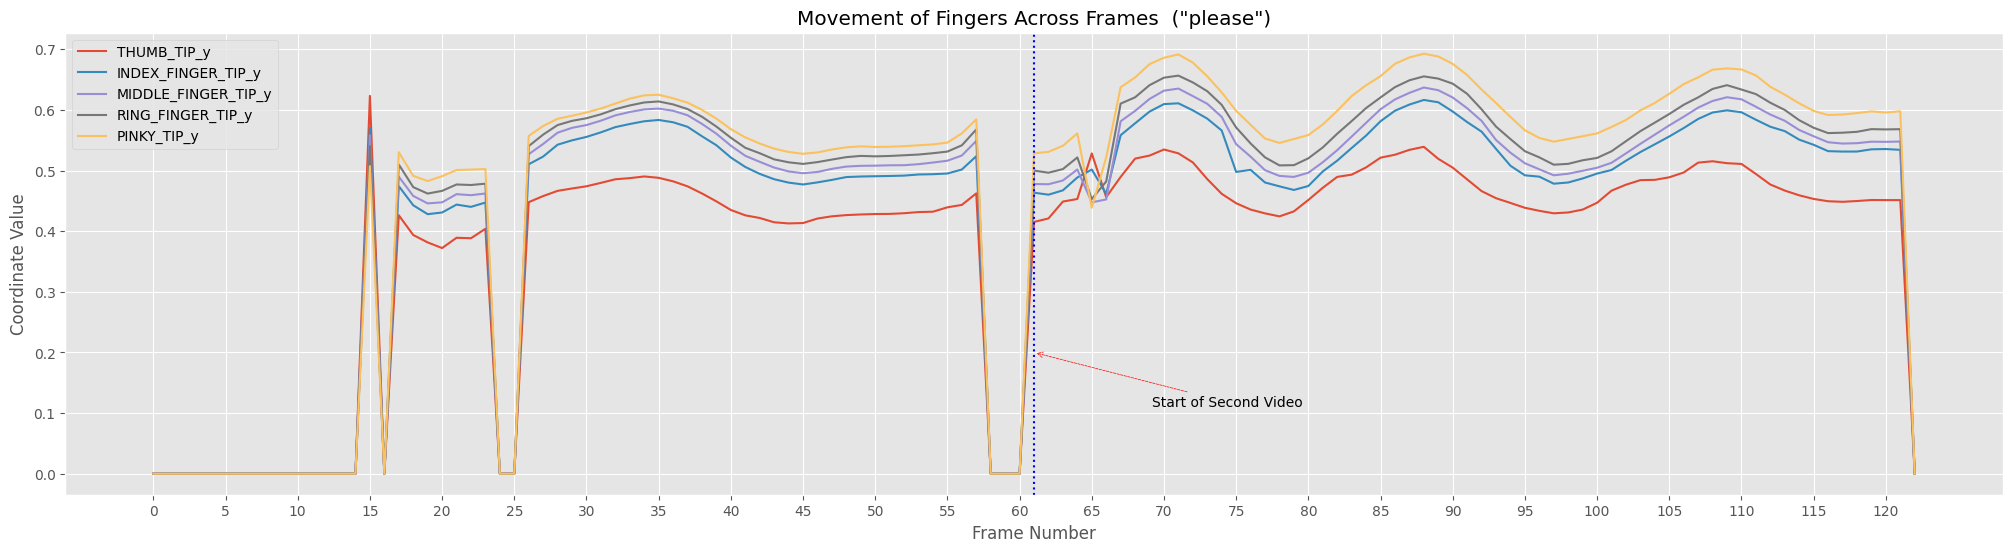

In [27]:
# plot the graph for finger movements across the frames over 2 video clips

# Set 'frame' as index if not already set
please_2_vid.set_index(np.arange(len(please_2_vid)), inplace=True)


plt.figure(figsize=(25, 6))
# Loop through the columns and plot them as separate lines
for col in columns_list:
    plt.plot(please_2_vid.index, please_2_vid[col], label=col)

plt.title('Movement of Fingers Across Frames  ("please")')
plt.xlabel('Frame Number')
plt.xticks(range(0,125,5))
plt.ylabel('Coordinate Value')


plt.axvline(61, color='blue', linestyle = ':')
# Add annotation
plt.annotate('Start of Second Video', xy=(61, 0.2), xytext=(0.6, 0.2),
                     textcoords="axes fraction", ha="center", va="center",
                     arrowprops=dict(arrowstyle="->", color="r", linestyle="--"))

plt.legend()
plt.grid(True)
plt.show()


The y values are normalized when extracted from MediaPipe Solutions. The origin starts from the top left corner. If the landmarks on the hand are detected at the bottom of the image, the y-value becomes closer to one and as the hand gets closer to the top of the screen, y-value decreases. However, landmarks that are not detected are represented by values of 0. In other words, the **lower** the person's wrists are in the image, the **higher the y-value as it is closer to the origin**. Conversely, if the person's wrist is high in the image, the y-value will be lower. 

In this plot for the action `please` we can observe a wavy motion following a action of the signer moving the hand in a circular motion. The degree of 'wave' depends on the extent of how the person signs. If the person signs with a big motion, the 'wave' will be more prominent and if its slight motion, the 'wave' will shallower. The number of 'wave' will also correlate to the number of circles the person signs. Additionally, the frequency of the 'wave' will depend on the number of action (circles).

In the first video clip (frames 0 - 60), we can see that the 'wave' motion is not as pronounced but a form is present. The hand of the signer was not detected until frame 14 which it did not detect again in frame 15 and 24. The action started at frame 14 and ended at frame 53. All of the fingers of the signer are spaced apart and the movement is consistent.

In the second video clip (from frame 61), a more pronounced wave motion can be observed with 3 crests. The signer started the action immediately and lasted throughout the duration of the video. There is a slight 'tangle' at about frame 5-7. Upon reviewing the clip, the person's thumb is consistently higher than the index finger, which might suggest MediaPipe having some difficulty detecting the landmarks for that moment.

In [28]:
# define a function to plot the video frames in 2 rows with 10 rows per row

def plot_images(images, titles):
    
    num_images = len(images)
    num_rows = 2
    num_cols = 10
    
    plt.figure(figsize=(20, 4))  # Adjust figure size for 2 rows of 10
    for i in range(min(num_images, num_rows * num_cols)):  # Ensure not to exceed the maximum number of subplots
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for Matplotlib
        plt.title(titles[i])
        plt.axis("off")  # Hide axes for cleaner visualization


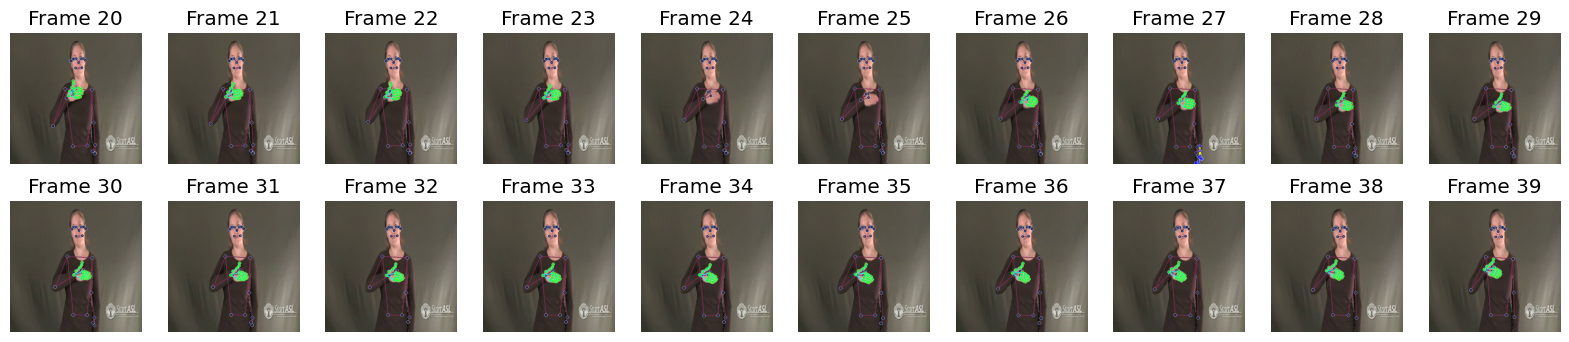

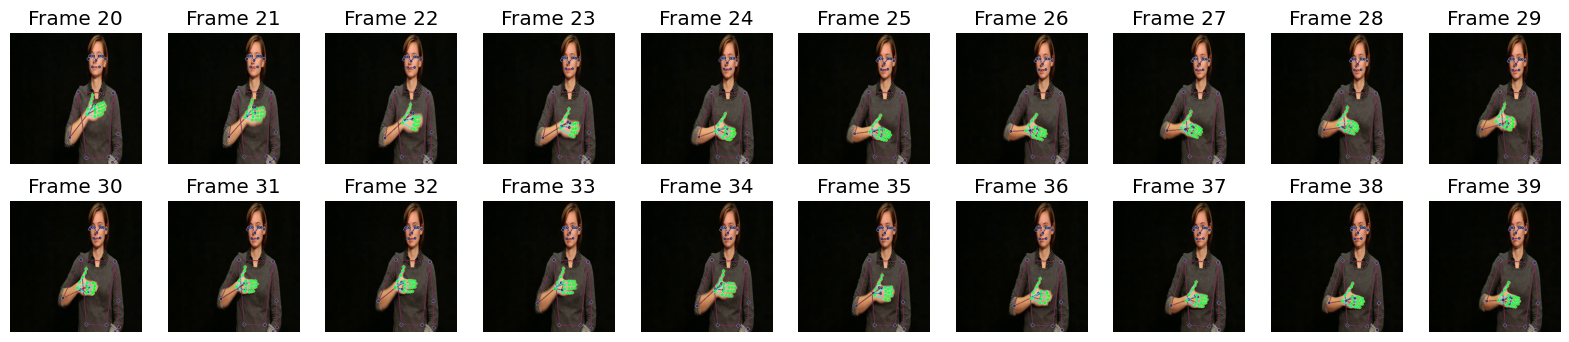

In [29]:
please_vid = ['../videos/train_data/output/please/please_1.mp4', '../videos/train_data/output/please/please_2.mp4']


for vid in please_vid:
    cap = cv2.VideoCapture(vid)

        
    # Setup MediaPipe model
    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        frame_count = 0

        images = []
        titles = []
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # Make detections
            image, results = mediapipe_detection(frame, holistic)

            # Draw landmarks
            draw_landmarks(image, results)

            if 20 <= frame_count <= 40:
                images.append(image)
                titles.append(f'Frame {frame_count}')


            # Show to screen
            cv2.imshow('OpenCV Feed', image)

            # Break gracefully
            if cv2.waitKey(10) & 0xFF == ord('q'):
                break

            frame_count += 1
        
        plot_images(images, titles)

    cap.release()
    cv2.destroyAllWindows()

From both set of images, the action for `please` is to place the open hand on the chest with thumb pointing upwards with the rest of the fingers are adjacent to each other while rubbing the chest in a circular motion. 

In the first set of images, the first person signs in a concentrated area in the middle of the chest. We can see that the circle drawn is concentrated indicating small movements which is reflected in the graph earlier. In frames 24 and 25 we can see that the wrists are not detected by MediaPipe even though the wrists are visible. This would explain the sharp decline and increase in the graph. 

In the second set of images, the second person signs in a broader circle around the middle of the torso. The hand moves from the middle of the chest to the sternum. This is reflected in the pronounced 'wave' in the graph earlier. 

### 3.4.2 'Sorry' Sign Word

In [30]:
sorry_df = pd.read_csv('../data/sorry_right_hand_landmarks.csv')

print(sorry_df.head())
print(sorry_df.shape) 

  action  frame  WRIST_x  WRIST_y  WRIST_z  THUMB_CMC_x  THUMB_CMC_y  THUMB_CMC_z  THUMB_MCP_x  THUMB_MCP_y  THUMB_MCP_z  THUMB_IP_x  THUMB_IP_y  THUMB_IP_z  THUMB_TIP_x  THUMB_TIP_y  THUMB_TIP_z  INDEX_FINGER_MCP_x  INDEX_FINGER_MCP_y  INDEX_FINGER_MCP_z  INDEX_FINGER_PIP_x  INDEX_FINGER_PIP_y  INDEX_FINGER_PIP_z  INDEX_FINGER_DIP_x  INDEX_FINGER_DIP_y  INDEX_FINGER_DIP_z  INDEX_FINGER_TIP_x  INDEX_FINGER_TIP_y  INDEX_FINGER_TIP_z  MIDDLE_FINGER_MCP_x  MIDDLE_FINGER_MCP_y  MIDDLE_FINGER_MCP_z  MIDDLE_FINGER_PIP_x  MIDDLE_FINGER_PIP_y  MIDDLE_FINGER_PIP_z  MIDDLE_FINGER_DIP_x  MIDDLE_FINGER_DIP_y  MIDDLE_FINGER_DIP_z  MIDDLE_FINGER_TIP_x  MIDDLE_FINGER_TIP_y  MIDDLE_FINGER_TIP_z  RING_FINGER_MCP_x  RING_FINGER_MCP_y  RING_FINGER_MCP_z  RING_FINGER_PIP_x  RING_FINGER_PIP_y  RING_FINGER_PIP_z  RING_FINGER_DIP_x  RING_FINGER_DIP_y  RING_FINGER_DIP_z  RING_FINGER_TIP_x  RING_FINGER_TIP_y  RING_FINGER_TIP_z  PINKY_MCP_x  PINKY_MCP_y  PINKY_MCP_z  PINKY_PIP_x  PINKY_PIP_y  PINKY_PIP_z  PINKY

In [32]:
# number of rows that has no values in the dataset containing 'sorry' signed word for right hand

count_rows_with_zeros = (sorry_df == 0.0).any(axis=1).sum()
total_rows = sorry_df.shape[0]

prop_no_values = count_rows_with_zeros/total_rows

print(f'''
      
      Number of rows with at least one value of 0.0: {count_rows_with_zeros} out of {total_rows} rows
      This would account to {prop_no_values:.2%}. These would indicate that these rows are either from
      the padded frames, the right wrist has not come into frame, or that MediaPipe is having difficulties
      detecting the landmarks on the hand.
      
      ''')




      
      Number of rows with at least one value of 0.0: 4195 out of 8472 rows
      This would account to 49.52%. These would indicate that these rows are either from
      the padded frames, the right wrist has not come into frame, or that MediaPipe is having difficulties
      detecting the landmarks on the hand.
      
      


We want to be able to plot a certain number of videos. We know that that each new video starts at `frame == 0`. We will subset the dataframe to return us the index of those rows

In [33]:
# extract 2 videos to plot

print(sorry_df[sorry_df['frame'] == 0].index.to_list()[:3])

# index from 0 to 122 would represent 2 video data

sorry_2_vid = sorry_df.iloc[0:123,:]

[0, 61, 122]


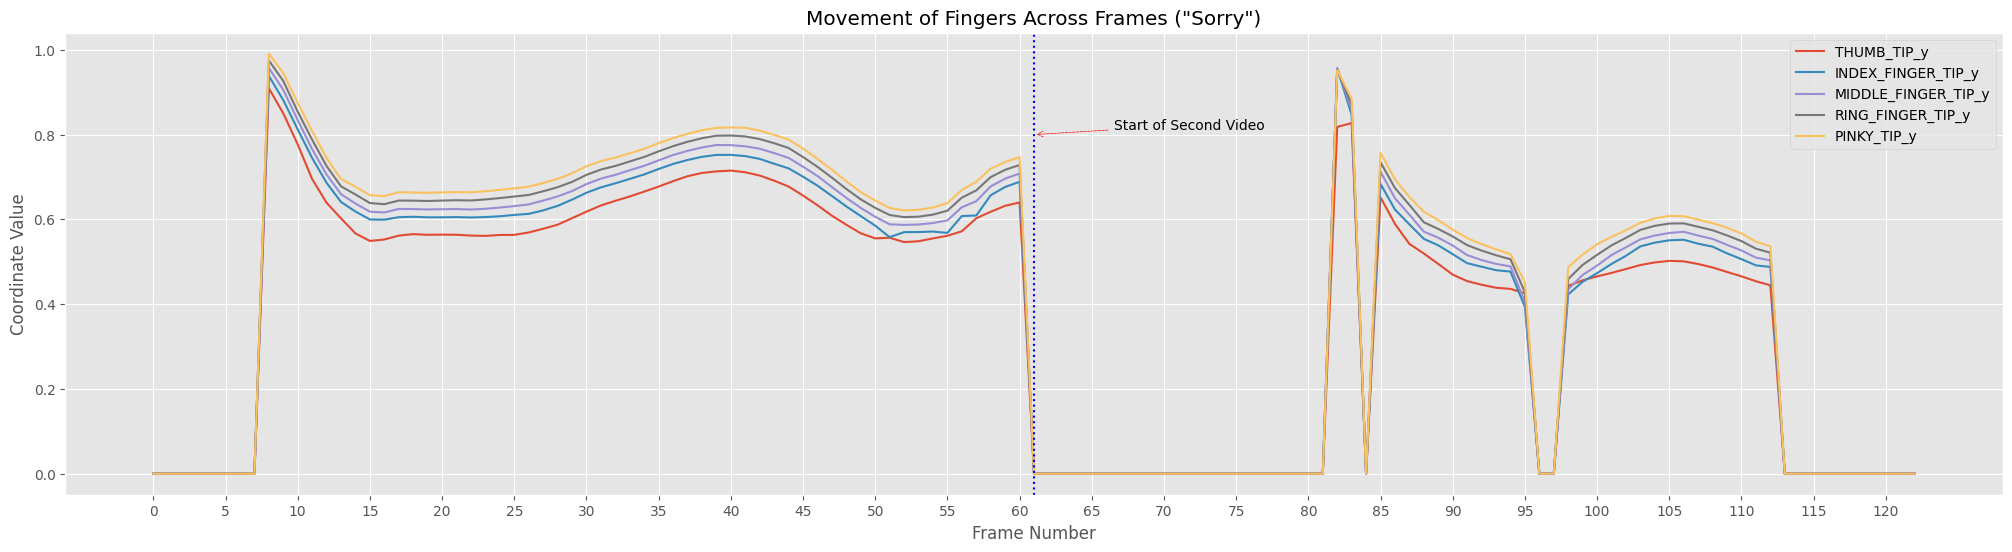

In [34]:
# plot the graph for finger movements across the frames over 2 video clips

# Set 'frame' as index if not already set
sorry_2_vid.set_index(np.arange(len(sorry_2_vid)), inplace=True)


plt.figure(figsize=(25, 6))
# Loop through the columns and plot them as separate lines
for col in columns_list:
    plt.plot(sorry_2_vid.index, sorry_2_vid[col], label=col)

plt.title('Movement of Fingers Across Frames ("Sorry")')
plt.xlabel('Frame Number')
plt.xticks(range(0,125,5))
plt.ylabel('Coordinate Value')


plt.axvline(61, color='blue', linestyle = ':')
# Add annotation
plt.annotate('Start of Second Video', xy=(61, 0.8), xytext=(0.58, 0.8),
                     textcoords="axes fraction", ha="center", va="center",
                     arrowprops=dict(arrowstyle="->", color="r", linestyle="--"))

plt.legend()
plt.grid(True)
plt.show()


In this plot for the action `sorry`, a gradual 'wave' motion can also be observed. Similar to the motion of `please`, if the motion is greater, the waves wil be more pronounced. As the palms are clenched into a fist, we can observe that the lines for each fingers are closer together as compared to `please` which has a bigger gap between.

In the first video (frames 0 - 60) we can see that the y-values are high, the signer starts from a low postion in the frame and starts a slow and gradual circular motion. This can be interpreted by the gradual increase and decrease in the 'wave' and the frequency between the crest are apart.

In the second video (frames 61 onwards), we can see that the action starts about 1/3 from the clip and MediaPipe had some difficulties detecting the hand landmarks. Similar to the first video, a similar pattern can be observed with the gradual and shallow 'wave' pattern.

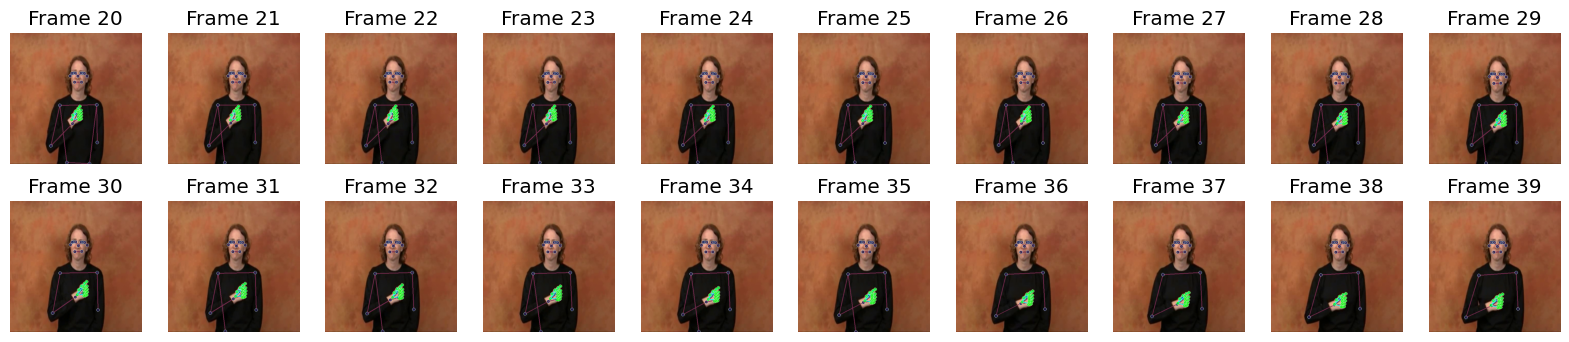

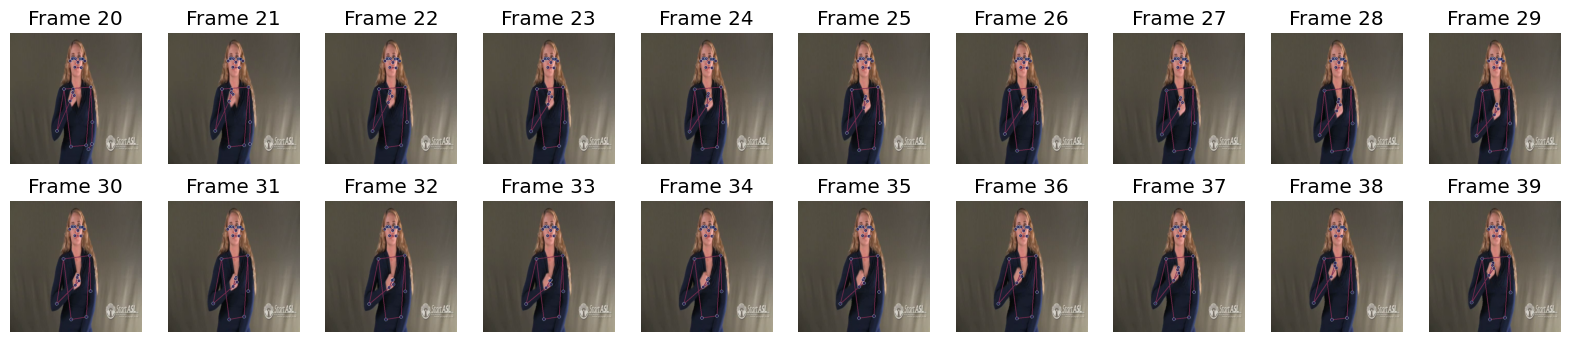

In [35]:
sorry_vid = ['../videos/train_data/output/sorry/sorry_1.mp4', '../videos/train_data/output/sorry/sorry_2.mp4']


for vid in sorry_vid:
    cap = cv2.VideoCapture(vid)

        
    # Setup MediaPipe model
    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        frame_count = 0

        images = []
        titles = []
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # Make detections
            image, results = mediapipe_detection(frame, holistic)

            # Draw landmarks
            draw_landmarks(image, results)

            if 20 <= frame_count <= 40:
                images.append(image)
                titles.append(f'Frame {frame_count}')


            # Show to screen
            cv2.imshow('OpenCV Feed', image)

            # Break gracefully
            if cv2.waitKey(10) & 0xFF == ord('q'):
                break

            frame_count += 1
        
        plot_images(images, titles)

    cap.release()
    cv2.destroyAllWindows()

From both set of images we can visually see that the motion of `sorry` frame by frame. The fist is clenched and placed on the chest, moving in a circular motion.

In the first image, we can see the gradual change in motion and the circle drawn with the fist is localized to a small area. At frame 38 and 39, the fists are low in the frame which corresponds to the graph earlier.

In the second image, we can see a similar motion but the fists are generally centered around the middle of the frame which would reflect in the graph. However, in this set of images, the drawing utilities for MediaPipe is not shown on the images but the data was captured. There were 2 instances that MediaPipe was not able to capture those landmarks which can be seen in the previous graph.

### 3.4.3 'Hello' Sign Word

In [38]:
# subset hello into its own dataframe

hello_df = pd.read_csv('../data/hello_right_hand_landmarks.csv')

print(hello_df.head()) # inspect dataframe
print(hello_df.shape) # 7448 frames

  action  frame  WRIST_x  WRIST_y  WRIST_z  THUMB_CMC_x  THUMB_CMC_y  THUMB_CMC_z  THUMB_MCP_x  THUMB_MCP_y  THUMB_MCP_z  THUMB_IP_x  THUMB_IP_y  THUMB_IP_z  THUMB_TIP_x  THUMB_TIP_y  THUMB_TIP_z  INDEX_FINGER_MCP_x  INDEX_FINGER_MCP_y  INDEX_FINGER_MCP_z  INDEX_FINGER_PIP_x  INDEX_FINGER_PIP_y  INDEX_FINGER_PIP_z  INDEX_FINGER_DIP_x  INDEX_FINGER_DIP_y  INDEX_FINGER_DIP_z  INDEX_FINGER_TIP_x  INDEX_FINGER_TIP_y  INDEX_FINGER_TIP_z  MIDDLE_FINGER_MCP_x  MIDDLE_FINGER_MCP_y  MIDDLE_FINGER_MCP_z  MIDDLE_FINGER_PIP_x  MIDDLE_FINGER_PIP_y  MIDDLE_FINGER_PIP_z  MIDDLE_FINGER_DIP_x  MIDDLE_FINGER_DIP_y  MIDDLE_FINGER_DIP_z  MIDDLE_FINGER_TIP_x  MIDDLE_FINGER_TIP_y  MIDDLE_FINGER_TIP_z  RING_FINGER_MCP_x  RING_FINGER_MCP_y  RING_FINGER_MCP_z  RING_FINGER_PIP_x  RING_FINGER_PIP_y  RING_FINGER_PIP_z  RING_FINGER_DIP_x  RING_FINGER_DIP_y  RING_FINGER_DIP_z  RING_FINGER_TIP_x  RING_FINGER_TIP_y  RING_FINGER_TIP_z  PINKY_MCP_x  PINKY_MCP_y  PINKY_MCP_z  PINKY_PIP_x  PINKY_PIP_y  PINKY_PIP_z  PINKY

In [39]:
# number of rows that has no values in the dataset containing 'hello' signed word for right hand

count_rows_with_zeros = (hello_df == 0.0).any(axis=1).sum()
total_rows = hello_df.shape[0]

prop_no_values = count_rows_with_zeros/total_rows

print(f'''
      
      Number of rows with at least one value of 0.0: {count_rows_with_zeros} out of {total_rows} rows
      This would account to {prop_no_values:.2%}. These would indicate that these rows are either from
      the padded frames, the right wrist has not come into frame, or that MediaPipe is having difficulties
      detecting the landmarks on the hand.
      
      ''')




      
      Number of rows with at least one value of 0.0: 3413 out of 7448 rows
      This would account to 45.82%. These would indicate that these rows are either from
      the padded frames, the right wrist has not come into frame, or that MediaPipe is having difficulties
      detecting the landmarks on the hand.
      
      


In [40]:
# extract 2 videos to plot

print(hello_df[hello_df['frame'] == 0].index.to_list()[:3])

# index from 0 to 122 would represent 2 video data

hello_2_vid = hello_df.iloc[0:123,:]

[0, 61, 122]


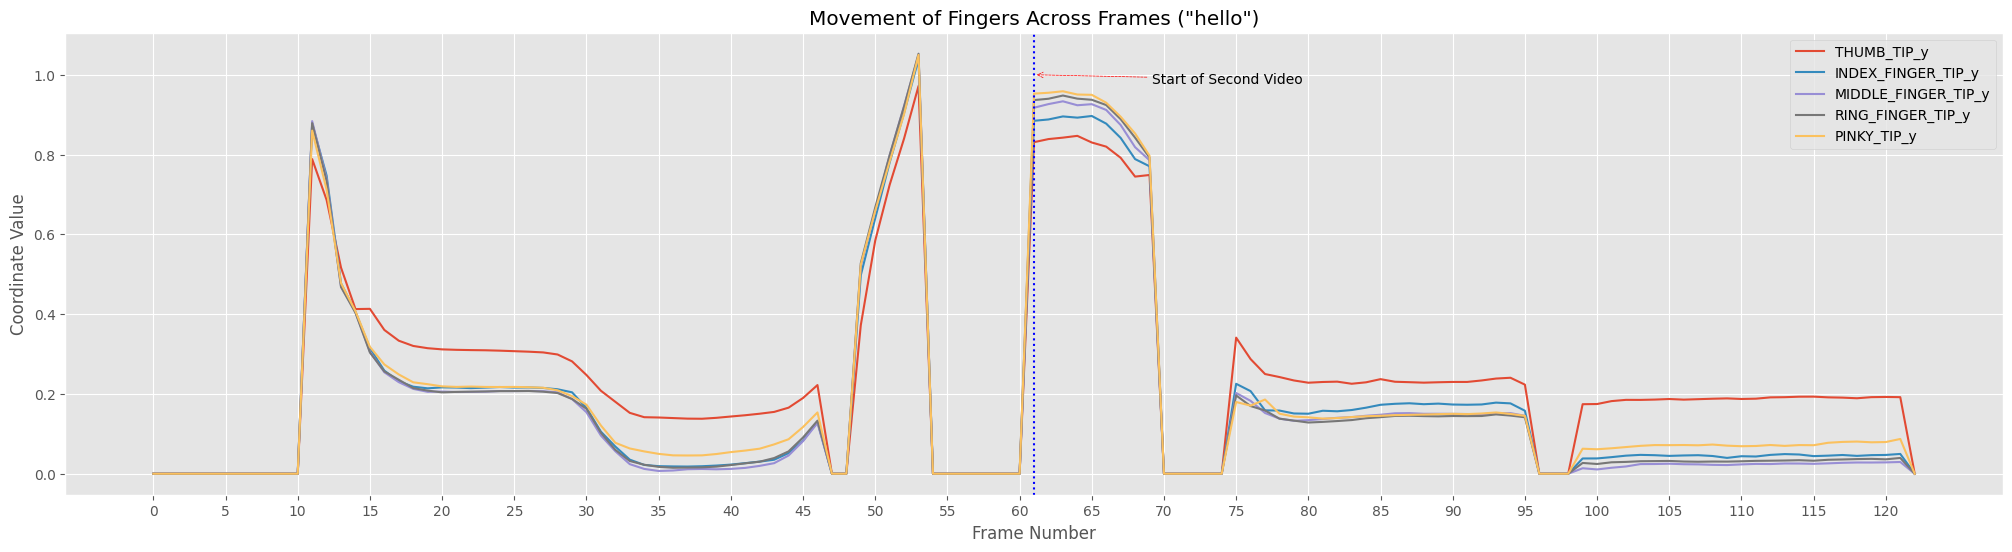

In [41]:
# plot the graph for finger movements across the frames over 2 video clips

# Set 'frame' as index if not already set
hello_2_vid.set_index(np.arange(len(hello_2_vid)), inplace=True)


plt.figure(figsize=(25, 6))
# Loop through the columns and plot them as separate lines
for col in columns_list:
    plt.plot(hello_2_vid.index, hello_2_vid[col], label=col)

plt.title('Movement of Fingers Across Frames ("hello")')
plt.xlabel('Frame Number')
plt.xticks(range(0,125,5))
plt.ylabel('Coordinate Value')


plt.axvline(61, color='blue', linestyle = ':')
# Add annotation
plt.annotate('Start of Second Video', xy=(61, 1), xytext=(0.6, 0.9),
                     textcoords="axes fraction", ha="center", va="center",
                     arrowprops=dict(arrowstyle="->", color="r", linestyle="--"))

plt.legend()
plt.grid(True)
plt.show()


In this plot for the action `hello`, we can observe 2 seperate plateaus in both videos. The movement involves placing the hand on the forehead before waving away from the head. Depends on the person, the hand can move side to side or upwards and sideways. Generally, the second part of the movement will cause the hand to go in an upwards motion. This is akin to an informal salute(hello) to a friend. 

In the first graph, the person places the hand on the forehead about 2/3 of the frame which the first plateau is generated. The second plateu occurs during the second part of the movement where the hand moves away from the head and goes in an upward angle. We see that the value dropped to zero. Upon inspecting the video, this was caused by the hand moving above the frame, which there is an exponential increase in the y-axis, indicating that the hand is going back down toward the frame in a fast pace.

In the second graph, we can observe the first plateau where the person places the hand on the head. The second motion is too fast that MediaPipe is not able to capture that change in hand position but a second plateau is generated indicating that stationary position of the hand in the second phase. 

We also observed that the thumb (red line) is on the opposite from `please` and `sorry`. This would indicate that the palm is upside down. Moreover, the other fingers are closed together which can be observed by the tight gap between the other lines.

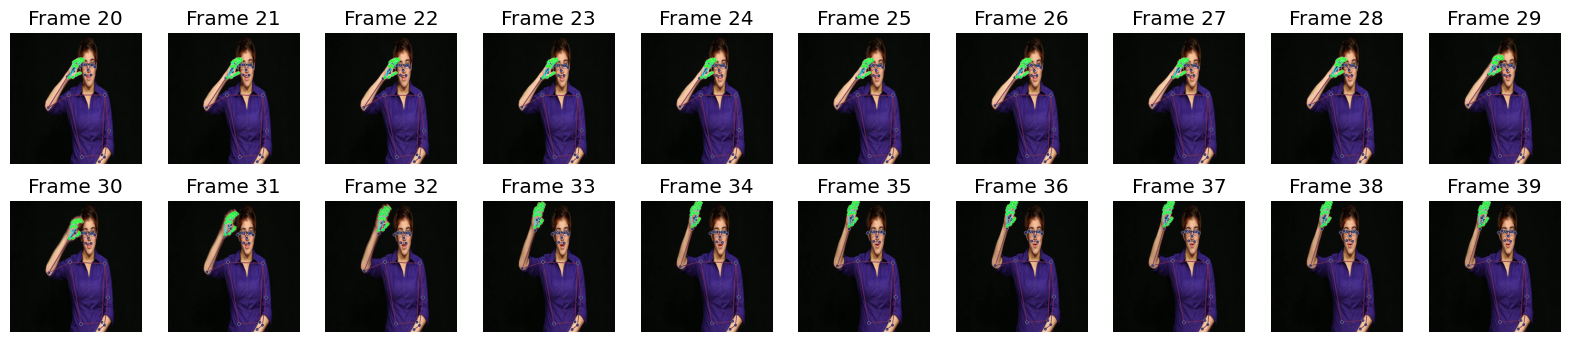

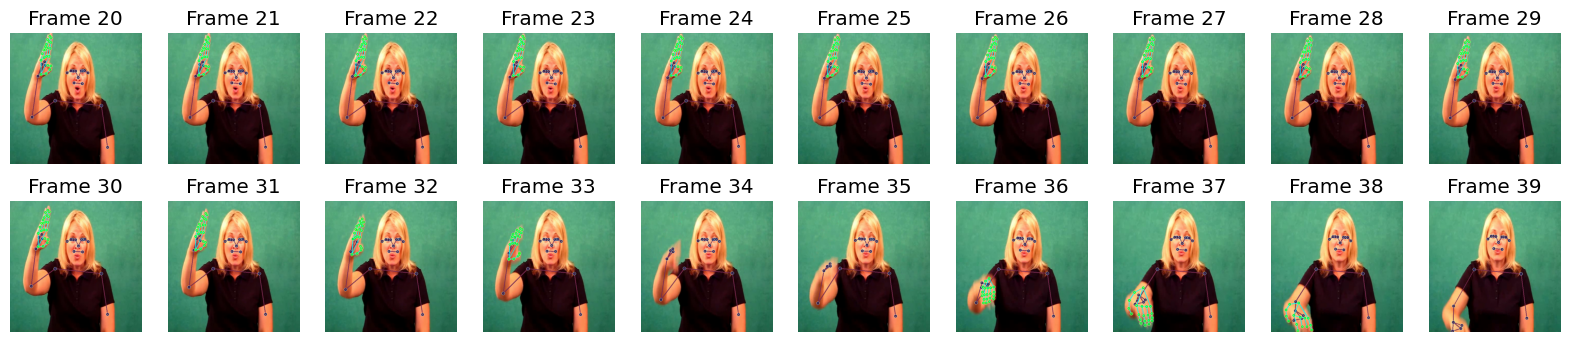

In [42]:
hello_vid = ['../videos/train_data/output/hello/hello_1.mp4', '../videos/train_data/output/hello/hello_2.mp4']


for vid in hello_vid:
    cap = cv2.VideoCapture(vid)

        
    # Setup MediaPipe model
    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        frame_count = 0

        images = []
        titles = []
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # Make detections
            image, results = mediapipe_detection(frame, holistic)

            # Draw landmarks
            draw_landmarks(image, results)

            if 20 <= frame_count <= 40:
                images.append(image)
                titles.append(f'Frame {frame_count}')

            # # Plot the image with MediaPipe results (or just the image)
            # plot_image(image, title=f'Frame {frame_count}')  # Include frame count in title for reference

            # Show to screen
            cv2.imshow('OpenCV Feed', image)

            # Break gracefully
            if cv2.waitKey(10) & 0xFF == ord('q'):
                break

            frame_count += 1
        
        plot_images(images, titles)

    cap.release()
    cv2.destroyAllWindows()


We can see from the plot that the the action for `hello` have lower ranges for y as it looks like a *salute*. With the hand movement coming from the bottom of the screen to the temple of the head.

Comparing the images from frame 20 to 40, we can observe the motion of the hands along the graph. At the start of frame 20, both signers raised their hands at different height, the first signer has a lower finger height than the second signer. Thus, the y-values of the graph are higher than the second video. As we follow along the frames, the first signer executes the `hello` action by raising her hand higher than the position on frame 20, where we can see the y-values decrease (hand raised higher than before). However, the second signer has a consistent height through out the frames until she puts down her hand. 

There are a couple of frames that MediaPipe is unable to capture the landmarks of the wrist of the second signer (frame 34 and 35 of the image) which is shown as a value of 0 in the plot (frame 96-98)

## 3.5  Cluster Analysis

In [43]:
please_fingers_df = please_df[columns_list]

print(please_fingers_df.describe())

        THUMB_TIP_y  INDEX_FINGER_TIP_y  MIDDLE_FINGER_TIP_y  RING_FINGER_TIP_y   PINKY_TIP_y
count  13904.000000        13904.000000         13904.000000       13904.000000  13904.000000
mean       0.426786            0.458175             0.471994           0.489403      0.514565
std        0.278680            0.298456             0.306152           0.314911      0.327238
min        0.000000            0.000000             0.000000           0.000000      0.000000
25%        0.000000            0.000000             0.000000           0.000000      0.000000
50%        0.493294            0.520512             0.539973           0.563250      0.606730
75%        0.588233            0.644663             0.663385           0.692013      0.730147
max        1.036081            1.109209             1.112179           1.108471      1.091380


In [44]:
sorry_fingers_df = sorry_df[columns_list]

print(sorry_fingers_df.describe())

       THUMB_TIP_y  INDEX_FINGER_TIP_y  MIDDLE_FINGER_TIP_y  RING_FINGER_TIP_y  PINKY_TIP_y
count  8472.000000         8472.000000          8472.000000        8472.000000  8472.000000
mean      0.312345            0.330928             0.343653           0.355097     0.365379
std       0.321525            0.338982             0.350812           0.361649     0.371549
min       0.000000            0.000000             0.000000           0.000000     0.000000
25%       0.000000            0.000000             0.000000           0.000000     0.000000
50%       0.253592            0.321172             0.346186           0.361967     0.361331
75%       0.602220            0.643492             0.675157           0.698283     0.719264
max       1.006561            1.051922             1.089319           1.122931     1.155476


In [45]:
hello_fingers_df = hello_df[columns_list]

print(hello_fingers_df.describe())

       THUMB_TIP_y  INDEX_FINGER_TIP_y  MIDDLE_FINGER_TIP_y  RING_FINGER_TIP_y  PINKY_TIP_y
count  7448.000000         7448.000000          7448.000000        7448.000000  7448.000000
mean      0.212372            0.168999             0.165493           0.172521     0.187632
std       0.257381            0.265302             0.270347           0.273378     0.276095
min       0.000000           -0.015675            -0.031170          -0.022986    -0.002792
25%       0.000000            0.000000             0.000000           0.000000     0.000000
50%       0.166049            0.040810             0.024515           0.033789     0.068292
75%       0.326674            0.234641             0.228217           0.239619     0.263960
max       1.061755            1.127346             1.119662           1.114218     1.113819


In [46]:
# merge dataframes

merged_df = pd.concat([please_df, sorry_df, hello_df], ignore_index=True)

print(merged_df.head()) # inspect dataframe

   action  frame  WRIST_x  WRIST_y  WRIST_z  THUMB_CMC_x  THUMB_CMC_y  THUMB_CMC_z  THUMB_MCP_x  THUMB_MCP_y  THUMB_MCP_z  THUMB_IP_x  THUMB_IP_y  THUMB_IP_z  THUMB_TIP_x  THUMB_TIP_y  THUMB_TIP_z  INDEX_FINGER_MCP_x  INDEX_FINGER_MCP_y  INDEX_FINGER_MCP_z  INDEX_FINGER_PIP_x  INDEX_FINGER_PIP_y  INDEX_FINGER_PIP_z  INDEX_FINGER_DIP_x  INDEX_FINGER_DIP_y  INDEX_FINGER_DIP_z  INDEX_FINGER_TIP_x  INDEX_FINGER_TIP_y  INDEX_FINGER_TIP_z  MIDDLE_FINGER_MCP_x  MIDDLE_FINGER_MCP_y  MIDDLE_FINGER_MCP_z  MIDDLE_FINGER_PIP_x  MIDDLE_FINGER_PIP_y  MIDDLE_FINGER_PIP_z  MIDDLE_FINGER_DIP_x  MIDDLE_FINGER_DIP_y  MIDDLE_FINGER_DIP_z  MIDDLE_FINGER_TIP_x  MIDDLE_FINGER_TIP_y  MIDDLE_FINGER_TIP_z  RING_FINGER_MCP_x  RING_FINGER_MCP_y  RING_FINGER_MCP_z  RING_FINGER_PIP_x  RING_FINGER_PIP_y  RING_FINGER_PIP_z  RING_FINGER_DIP_x  RING_FINGER_DIP_y  RING_FINGER_DIP_z  RING_FINGER_TIP_x  RING_FINGER_TIP_y  RING_FINGER_TIP_z  PINKY_MCP_x  PINKY_MCP_y  PINKY_MCP_z  PINKY_PIP_x  PINKY_PIP_y  PINKY_PIP_z  PINK

In [47]:
# check that all actions are combined in the dataframe
action_class = merged_df['action'].unique()

print(action_class)

['please' 'sorry' 'hello']


In [48]:
# Write the merged DataFrame to a new CSV file
merged_df.to_csv('../data/merged_file.csv', index=False)

In [49]:
print(columns_list)

['THUMB_TIP_y', 'INDEX_FINGER_TIP_y', 'MIDDLE_FINGER_TIP_y', 'RING_FINGER_TIP_y', 'PINKY_TIP_y']


In [50]:
fingers_df = merged_df[['action', 'THUMB_TIP_y', 'INDEX_FINGER_TIP_y', 'MIDDLE_FINGER_TIP_y', 'RING_FINGER_TIP_y', 'PINKY_TIP_y']]

print(fingers_df.describe())

        THUMB_TIP_y  INDEX_FINGER_TIP_y  MIDDLE_FINGER_TIP_y  RING_FINGER_TIP_y   PINKY_TIP_y
count  29824.000000        29824.000000         29824.000000       29824.000000  29824.000000
mean       0.340731            0.349812             0.358994           0.372116      0.390540
std        0.299845            0.324779             0.335072           0.344221      0.354685
min        0.000000           -0.015675            -0.031170          -0.022986     -0.002792
25%        0.000000            0.000000             0.000000           0.000000      0.000000
50%        0.424349            0.438793             0.451604           0.472398      0.503254
75%        0.560366            0.612557             0.635220           0.659585      0.693460
max        1.061755            1.127346             1.119662           1.122931      1.155476


In [51]:
# Select features 
labels = columns_list
X = merged_df[labels]

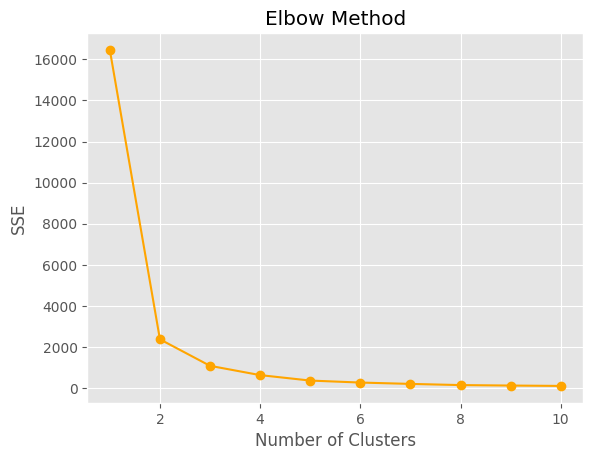

In [52]:
# elbow plot
sse = []
for k in range(1, 11):  # Test a range of cluster numbers, here 1 through 10
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)  # Sum of squared distances to closest cluster center

plt.plot(range(1, 11), sse, marker='o', color = 'orange')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.title('Elbow Method')
plt.show()


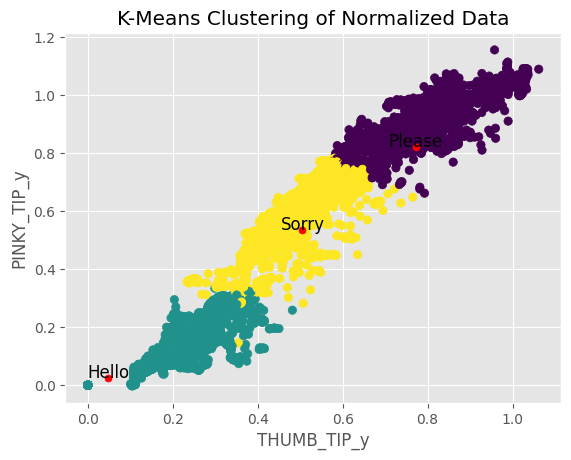

In [54]:
# Based on the number of classes we have and the elbow plot, our k=3
k = 3  # 3 classes ['please', 'sorry', 'hello']

# Initialize K-Means
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)

# Fit the model to the normalized data
clusters = kmeans.fit_predict(X)  # `data` should be your normalized dataset



# Scatter plot
plt.scatter(X['THUMB_TIP_y'], X['PINKY_TIP_y'], c=clusters, cmap='viridis')
centers = kmeans.cluster_centers_


cluster_labels = {0: 'Please', 1: 'Hello', 2: 'Sorry'}

# Add centroids
for i, center in enumerate(centers):
    plt.scatter(center[0], center[1], c='red', marker='.', s=100)
    plt.text(center[0], center[1], cluster_labels[i], fontsize=12, ha='center')

# add plot info
plt.title('K-Means Clustering of Normalized Data')
plt.xlabel('THUMB_TIP_y')
plt.ylabel('PINKY_TIP_y')
# plt.legend()
plt.show()



## 3.6 PCA

In [55]:
# Initialize PCA
pca = PCA(n_components=2)  # Reduce the dataset to 2 dimensions for visualization
principalComponents = pca.fit_transform(X)

# Create a DataFrame for the PCA results
principalDf = pd.DataFrame(data=principalComponents, columns=['Principal Component 1', 'Principal Component 2'])



**Scree Plot or a Cumulative Explained Variance Plot**
It is used in principal component analysis (PCA) to help determine the number of principal components to use by showing the cumulative proportion of the total variance in the data that is explained by the first *n* components.

Purpose of the Scree Plot:
Variance Explained: The y-axis shows the cumulative percentage of the variance explained by the principal components, which provides insight into how much information (variance) is captured by each additional component.

Component Selection: The x-axis indicates the number of principal components. The plot helps in deciding how many components are necessary to capture a significant amount of variability in the data. A common practice is to choose the number of components at the point where the plot shows an 'elbow'; this is where the rate of increase in explained variance significantly slows down, suggesting diminishing returns by adding more components.

Interpretation:
Elbow Method: You look for a point where the increase in the explained variance ratio begins to level off (forming an elbow), suggesting that subsequent principal components contribute less to capturing the variability in the data. The number of components before this point is often considered sufficient for most analytical purposes.

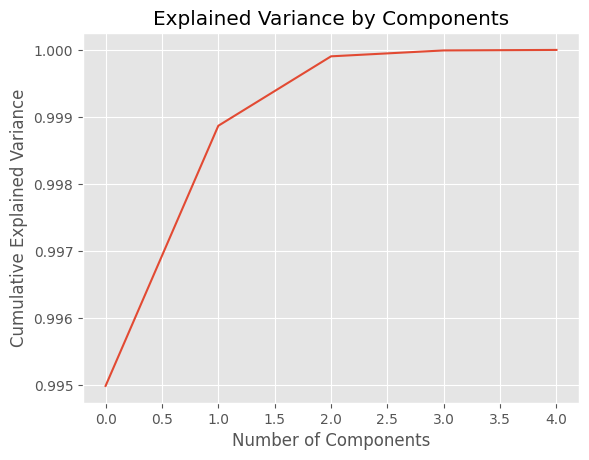

In [56]:
# Scree plot

pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Components')
plt.show()

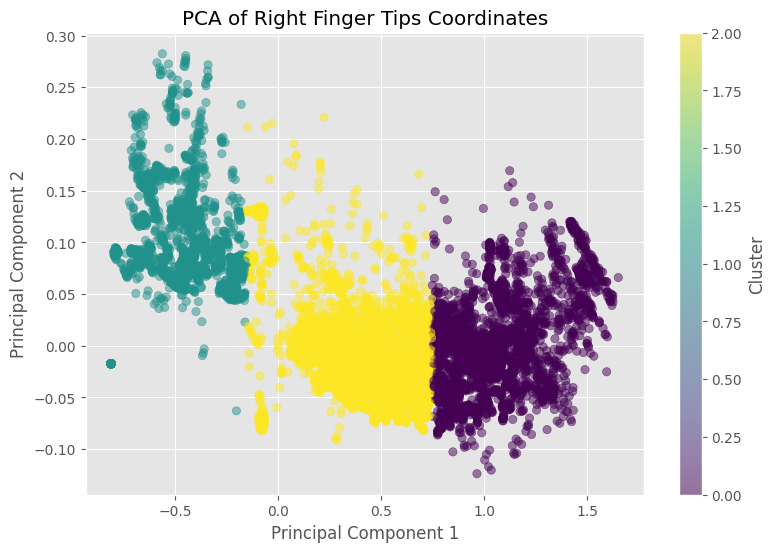

In [57]:
# plot PCA

# Assuming `clusters` is available from previous K-means or other clustering
plt.figure(figsize=(9, 6))
plt.scatter(principalDf['Principal Component 1'], principalDf['Principal Component 2'],
            c=clusters,  # Color by cluster labels if available
            cmap='viridis', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Right Finger Tips Coordinates')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()


In [58]:
print(f"Explained variance by component: {pca.explained_variance_ratio_}")


Explained variance by component: [9.94984295e-01 3.88330459e-03 1.03671520e-03 8.81107087e-05
 7.57446905e-06]
